In [1]:
import os
import glob

In [2]:
IMG_DIR = "../input/vid_dump"
ann_files = glob.glob("../input/annotation/*")
pic_files = [t.replace("annotation","vid_dump").replace("xml","jpg") for t in ann_files]
classes = ['signal', 'car', 'board', 'sign', 'person']

In [3]:
classes.index("car")

1

In [4]:
import numpy as np
import pandas as pd
import torch
import os
import random

import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
%matplotlib inline

import cv2
import itertools
import copy


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

In [5]:
import xmltodict
import json
ann_files[0]

'../input/annotation/7900.xml'

In [6]:

# with open(ann_files[0]) as xml_file:
with open("../input/annotation/2600.xml") as xml_file:
    data_dict = xmltodict.parse(xml_file.read())
data_dict["annotation"]["object"]#["bndbox"]#["xmin"] 
pd.DataFrame([data_dict["annotation"]["object"]] )

,name,pose,truncated,difficult,bndbox
0,sign,Unspecified,0,0,"{'xmin': '635', 'ymin': '372', 'xmax': '652', ..."


In [7]:
try:
    tempdf = pd.DataFrame(data_dict["annotation"]["object"] )
    for c in ["xmin","ymin","xmax","ymax"]:
        tempdf[c] = tempdf["bndbox"].apply(lambda x: x[c])
    tempdf["filename"] = data_dict["annotation"]["filename"]
    tempdf["path"] = data_dict["annotation"]["path"]
    tempdf["height"] = data_dict["annotation"]["size"]["height"]
    tempdf["width"] = data_dict["annotation"]["size"]["width"]     
    tempdf["image_id"] = tempdf["filename"].str.strip(".jpg")
    tempdf["source"] = tempdf["name"]
except:
    tempdf = pd.DataFrame([data_dict["annotation"]["object"]] )
    for c in ["xmin","ymin","xmax","ymax"]:
        tempdf[c] = tempdf["bndbox"].apply(lambda x: x[c])
    tempdf["filename"] = data_dict["annotation"]["filename"]
    tempdf["path"] = data_dict["annotation"]["path"]
    tempdf["height"] = data_dict["annotation"]["size"]["height"]
    tempdf["width"] = data_dict["annotation"]["size"]["width"]     
    tempdf["image_id"] = tempdf["filename"].str.strip(".jpg")
    tempdf["source"] = tempdf["name"]


tempdf.head(2)

,name,pose,truncated,difficult,bndbox,xmin,ymin,xmax,ymax,filename,path,height,width,image_id,source
0,sign,Unspecified,0,0,"{'xmin': '635', 'ymin': '372', 'xmax': '652', ...",635,372,652,386,2600.jpg,/media/noufal/B400D1FE00D1C80E/Users/Gigatech/...,700,700,2600,sign


In [8]:
def convert_to_df(file_list):
    df = pd.DataFrame()
    for file in file_list:
        with open(file) as xml_file:
            data_dict = xmltodict.parse(xml_file.read())
        try:
            tempdf = pd.DataFrame(data_dict["annotation"]["object"] )
            for c in ["xmin","ymin","xmax","ymax"]:
                tempdf[c] = tempdf["bndbox"].apply(lambda x: x[c])
            tempdf["filename"] = data_dict["annotation"]["filename"]

            tempdf["height"] = data_dict["annotation"]["size"]["height"]
            tempdf["width"] = data_dict["annotation"]["size"]["width"]     
            tempdf["image_id"] = tempdf["filename"].str.strip(".jpg")
            tempdf["source"] = tempdf["name"]
            tempdf["path"] = tempdf.apply(lambda x: os.path.join(IMG_DIR,x["image_id"]+".jpg"),axis=1)
        except:
            tempdf = pd.DataFrame([data_dict["annotation"]["object"]] )
            for c in ["xmin","ymin","xmax","ymax"]:
                tempdf[c] = tempdf["bndbox"].apply(lambda x: x[c])
            tempdf["filename"] = data_dict["annotation"]["filename"]
            
            tempdf["height"] = data_dict["annotation"]["size"]["height"]
            tempdf["width"] = data_dict["annotation"]["size"]["width"]     
            tempdf["image_id"] = tempdf["filename"].str.strip(".jpg")
            tempdf["source"] = tempdf["name"]
            tempdf["path"] = tempdf.apply(lambda x: os.path.join(IMG_DIR,x["image_id"]+".jpg"),axis=1)
        if df.empty:
            df = tempdf.copy()
        else:
            df = df.append(tempdf,ignore_index=True)
    return df

In [9]:
df = convert_to_df(ann_files)
print(df.shape)
df.head()

(1308, 15)


,name,pose,truncated,difficult,bndbox,xmin,ymin,xmax,ymax,filename,height,width,image_id,source,path
0,signal,Unspecified,0,0,"{'xmin': '504', 'ymin': '285', 'xmax': '514', ...",504,285,514,306,7900.jpg,700,700,7900,signal,../input/vid_dump/7900.jpg
1,signal,Unspecified,0,0,"{'xmin': '556', 'ymin': '333', 'xmax': '561', ...",556,333,561,346,7900.jpg,700,700,7900,signal,../input/vid_dump/7900.jpg
2,signal,Unspecified,0,0,"{'xmin': '581', 'ymin': '331', 'xmax': '586', ...",581,331,586,344,7900.jpg,700,700,7900,signal,../input/vid_dump/7900.jpg
3,signal,Unspecified,0,0,"{'xmin': '654', 'ymin': '318', 'xmax': '661', ...",654,318,661,332,7900.jpg,700,700,7900,signal,../input/vid_dump/7900.jpg
4,car,Unspecified,0,0,"{'xmin': '222', 'ymin': '163', 'xmax': '491', ...",222,163,491,541,7900.jpg,700,700,7900,car,../input/vid_dump/7900.jpg


In [10]:
def show_image(image_id):
    
    fig, ax = plt.subplots(1, 2, figsize = (24, 24))
    ax = ax.flatten()
    
    bbox = df[df['image_id'] == image_id ]
    img_path = bbox["path"].values[0]
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['source']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,255,255), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        # print(label,x1,y1)
        cv2.putText(image2, label, (int(x1),int(int(y1)-10)), font, 1, (255,255,255), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


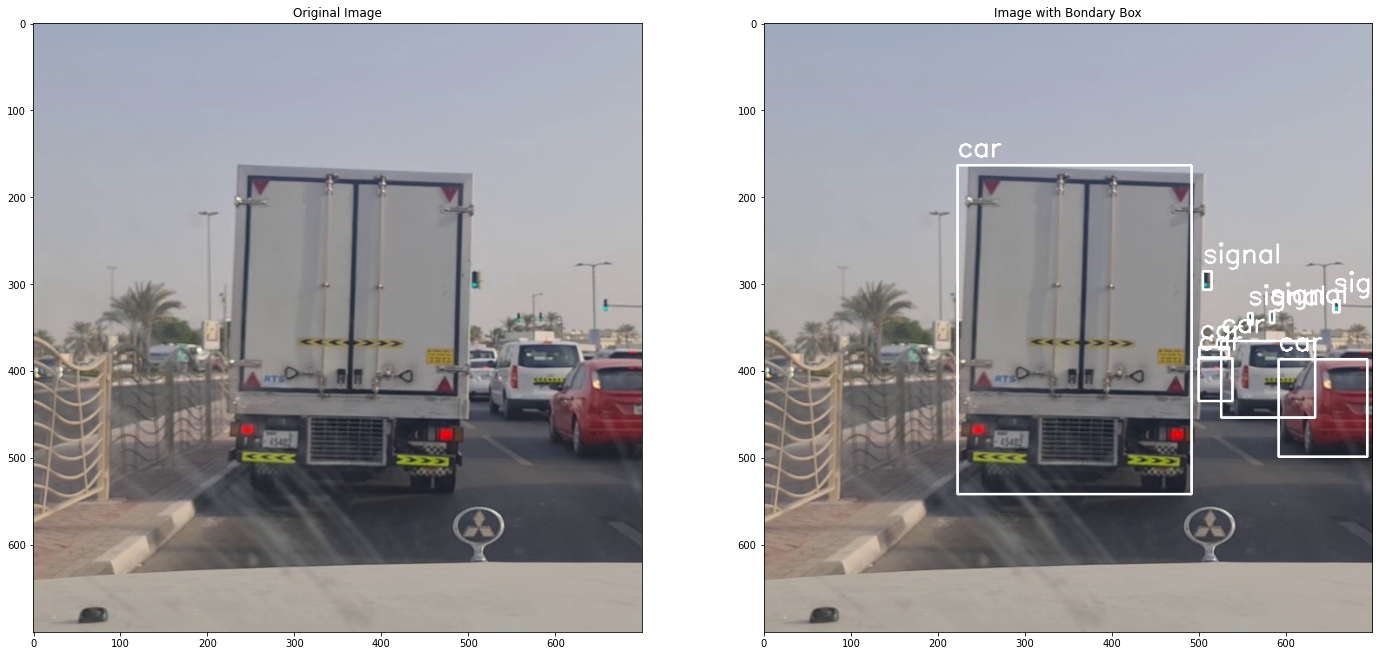

In [11]:
show_image("7900")
# df.loc[0,"path"]
# img_path = '../input/vid_dump/7900.jpg'
# cv2.imread(img_path, cv2.IMREAD_COLOR)

In [12]:
# split train, val
unique_files = df.image_id.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.90), replace = False))
train_df = df[df.image_id.isin(train_files)]
test_df = df[~df.image_id.isin(train_files)]
train_df.shape,test_df.shape,len(train_df.image_id.unique()), len(test_df.image_id.unique())

((1181, 15), (127, 15), 106, 12)

In [13]:
def custom_dataset(df, dir_image):
    
    dataset_dicts = []
    
    for img_id, img_name in enumerate(df.image_id.unique()):
        
        record = {}
        image_df = df[df['image_id'] == img_name]
        img_path = image_df["path"].values[0]
        
        record['file_name'] = img_path
        record['image_id'] = img_id
        record['height'] = int(image_df['height'].values[0])
        record['width'] = int(image_df['width'].values[0])
                
        objs = []
        for _, row in image_df.iterrows():
            
            x_min = int(row.xmin)
            y_min = int(row.ymin)
            x_max = int(row.xmax)
            y_max = int(row.ymax)
            
            poly = [(x_min, y_min), (x_max, y_min),
                    (x_max, y_max), (x_min, y_max) ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            obj = {
               "bbox": [x_min, y_min, x_max, y_max],
               "bbox_mode": BoxMode.XYXY_ABS,
               "segmentation": [poly],
               "category_id": classes.index(row["name"]),
               "iscrowd" : 0
                
                  }
            
            objs.append(obj)
            
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [14]:
def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((700,700)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

In [15]:
class DashcamTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [16]:
df["source"].unique()

array(['signal', 'car', 'board', 'sign', 'person'], dtype=object)

In [17]:
def register_dataset(df, dataset_label='dashcam_train', image_dir = "."):
    
    # Register dataset - if dataset is already registered, give it a new name    
    try:
        DatasetCatalog.register(dataset_label, lambda d=df: custom_dataset(df, image_dir))
        MetadataCatalog.get(dataset_label).set(thing_classes = classes)
    except:
        # Add random int to dataset name to not run into 'Already registered' error
        n = random.randint(1, 1000)
        dataset_label = dataset_label + str(n)
        DatasetCatalog.register(dataset_label, lambda d=df: custom_dataset(df, image_dir))
        MetadataCatalog.get(dataset_label).set(thing_classes = classes)

    return MetadataCatalog.get(dataset_label), dataset_label

In [18]:
metadata, train_dataset = register_dataset(train_df)
metadata, val_dataset = register_dataset(test_df, dataset_label='dashcam_test')

In [19]:
metadata

namespace(name='dashcam_test',
          thing_classes=['signal', 'car', 'board', 'sign', 'person'])

In [20]:
MODEL = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
MAX_ITER = 5000
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = (train_dataset,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR =  0.00025 
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512     
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DashcamTrainer(cfg)

[08/19 12:50:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [21]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[08/19 12:50:24 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/appuser/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[08/19 12:50:29 d2.utils.events]:  eta: 0:16:37  iter: 19  total_loss: 2.8  loss_cls: 1.75  loss_box_reg: 0.5564  loss_rpn_cls: 0.1553  loss_rpn_loc: 0.202  time: 0.2004  data_time: 0.0136  lr: 4.9953e-06  max_mem: 1528M
[08/19 12:50:32 d2.utils.events]:  eta: 0:16:06  iter: 39  total_loss: 2.666  loss_cls: 1.665  loss_box_reg: 0.528  loss_rpn_cls: 0.2084  loss_rpn_loc: 0.2332  time: 0.1938  data_time: 0.0045  lr: 9.9902e-06  max_mem: 1528M
[08/19 12:50:36 d2.utils.events]:  eta: 0:15:25  iter: 59  total_loss: 2.567  loss_cls: 1.464  loss_box_reg: 0.524  loss_rpn_cls: 0.2855  loss_rpn_loc: 0.2748  time: 0.1903  data_time: 0.0042  lr: 1.4985e-05  max_mem: 1528M
[08/19 12:50:40 d2.utils.events]:  eta: 0:15:09  iter: 79  total_loss: 2.155  loss_cls: 1.196  loss_box_reg: 0.526  loss_rpn_cls: 0.08767  loss_rpn_loc: 0.2165  time: 0.1887  data_time: 0.0043  lr: 1.998e-05  max_mem: 1528M
[08/19 12:50:43 d2.utils.events]:  eta: 0:15:05  iter: 99  total_loss: 1.857  loss_cls: 0.9059  loss_box_re

In [22]:
# Change the config


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
cfg.DATASETS.TEST = ('dashcam_test', )
predictor = DefaultPredictor(cfg)

In [23]:
evaluator = COCOEvaluator(val_dataset, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_dataset)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [08/19 13:06:03 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[08/19 13:06:03 d2.evaluation.coco_evaluation]: 'dashcam_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [08/19 13:06:03 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/dashcam_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[08/19 13:06:03 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   signal   | 21           |    car     | 70           |   board    | 18           |
|    sign    | 17           |   person   | 1            |            |              |
|   total    | 127          |     

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': 0.0,
               'AP-signal': 0.0,
               'AP-car': nan,
               'AP-board': nan,
               'AP-sign': nan,
               'AP-person': nan})])

In [40]:
inf_path

'../input/vid_dump/10900.jpg'

In [52]:

font = cv2.FONT_HERSHEY_SIMPLEX     
fontScale = 1 
color = (255, 255, 0)
thickness = 1

inf_path = df.sample()["path"].iloc[0]
inf_path = '../input/vid_dump/900.jpg'
inf_path = '../input/vid_dump/24900.jpg'
img = cv2.imread(inf_path)
outputs = predictor(img)
out = outputs["instances"].to("cpu")
out

Instances(num_instances=16, image_height=700, image_width=700, fields=[pred_boxes: Boxes(tensor([[521.1694, 356.0848, 607.0228, 415.3806],
        [564.9418, 392.4594, 698.5876, 537.9061],
        [426.6627, 382.4330, 473.1114, 421.5356],
        [395.7067, 380.6340, 421.2364, 402.1869],
        [320.8426, 380.6161, 336.1848, 394.8997],
        [372.4435, 379.4441, 395.4512, 396.6684],
        [356.8336, 370.5041, 378.6589, 394.7106],
        [631.9329, 378.1667, 694.7999, 394.4758],
        [360.7673, 372.6237, 394.1569, 396.2174],
        [345.0479, 381.6410, 355.1998, 392.5462],
        [308.0995, 382.5026, 322.1554, 394.4819],
        [575.5408, 389.0677, 634.9777, 420.9857],
        [359.1948, 380.2743, 374.1394, 395.0510],
        [446.8413, 360.3512, 459.1070, 375.3550],
        [339.5966,   0.0000, 644.2260, 149.9603],
        [345.2946, 375.6945, 358.8297, 392.5760]])), scores: tensor([0.9997, 0.9995, 0.9993, 0.9988, 0.9974, 0.9916, 0.9830, 0.9812, 0.9446,
        0.8980, 0.88

In [53]:
# df["path"].sample().iloc[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


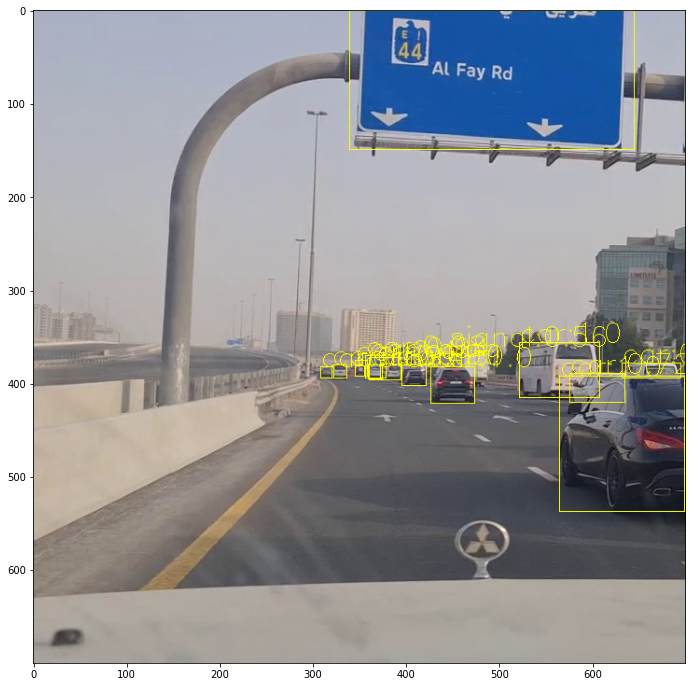

In [54]:
scores = out.get_fields()['scores'].numpy()
boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
labels= out.get_fields()['pred_classes'].numpy()
boxes = boxes.astype(int)
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
im /= 255.0

for b,s,l in zip(boxes,scores,labels):
    cv2.rectangle(im, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), color, thickness)
    cv2.putText(im, '{}:{:.2}'.format(classes[l],s), (b[0],b[1]), font, 1, color, thickness)
        
plt.figure(figsize=(12,12))
plt.imshow(im)

In [56]:
classes

['signal', 'car', 'board', 'sign', 'person']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


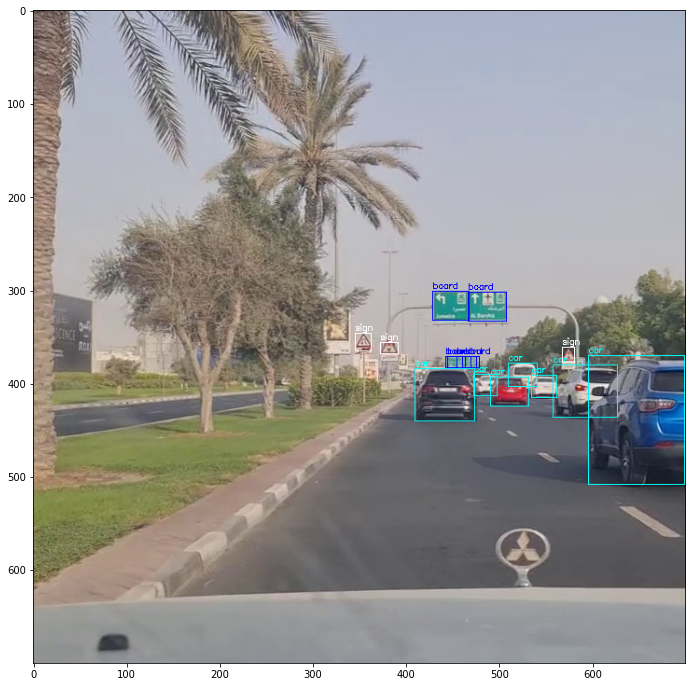

In [71]:


font = cv2.FONT_HERSHEY_SIMPLEX     
fontScale = 0.3 
color = (255, 0, 0)
thickness = 1

colors = {
    0:(255,0,0),
    1:(0,255,255),
    2:(0,0,255),
    3:(255,255,255),
    4:(255,255,0)
}

inf_path = test_df.sample()["path"].iloc[0]
img = cv2.imread(inf_path)
outputs = predictor(img)
out = outputs["instances"].to("cpu")
scores = out.get_fields()['scores'].numpy()
boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
labels= out.get_fields()['pred_classes'].numpy()
boxes = boxes.astype(int)
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
im /= 255.0

for b,s,l in zip(boxes,scores,labels):
    cv2.rectangle(im, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), colors[l], thickness)
    cv2.putText(im, '{}'.format(classes[l]), (b[0],b[1]-3), font, fontScale, colors[l], thickness)
        
plt.figure(figsize=(12,12))
plt.imshow(im)